In [ ]:
# Author - Harry Turner, Contributor.

In [ ]:
!pip install numpy==1.26.4 tqdm==4.66.2 scikit-learn==1.4.2 matplotlib==3.8.4 seaborn==0.13.2 mistralai==0.0.11 

In [1]:
import time
import random
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_20newsgroups
from mistralai.client import MistralClient

# Document Clustering

[Document Clustering](https://en.wikipedia.org/wiki/Document_clustering), which is similar to [Topic Modelling](https://monkeylearn.com/blog/introduction-to-topic-modeling/) is an unsupervised machine learning technique for discovering underlying structure in a collection of text documents. 

We shall use a subset of the 20 News Groups dataset to see if we can successfully model the different news topics. To do this, we'll use Mistral's Embedding API to generate text embeddings for these text documents, hopefully they'll capture the semantic content of the text that will let us use clustering techniques like T-SNE and K Means to discover that structure.

We'll go through these steps.

 - Fetch and subsample the dataset.
 - Generate embeddings using Mistral's Embedding API.
 - Project the embeddings into two dimensions and visualise with T-SNE.
 - Assign cluster labels to the embeddings using K Means and compare with the original target labels.

Let's get started.

# Fetch & Process Data

First we'll grab the dataset which is distributed via scikit learn. We'll grab the test dataset because it's smaller and easier to work with, it should only take a few seconds to download on a standard network connection.

In [2]:
newsgroups = fetch_20newsgroups(subset='test')
len(newsgroups['data'])

7532

To keep this example manageable, we'll select a subset of this data. First we'll select just five of the twenty categories to produce a smaller dataset we'll call fivenewsgroups. Then we'll select a random sample of 200 items from fivenewsgroups. Change this if you want more.

In [3]:
RANDOM_SAMPLE_SIZE = 200

In [4]:
# We'll select these five categories as they make a diverse set!
categories_to_select = {
    'talk': 'talk.politics.mideast',
    'sci': 'sci.space',
    'comp': 'comp.graphics',
    'rec': 'rec.sport.hockey',
    'soc': 'soc.religion.christian'
}

# Create a smaller dataset by filtering for data/targets belonging to the above categories.
selected_targets = [newsgroups.target_names.index(cat) for cat in categories_to_select.values()]
fivenewsgroups = [(text, target) for text, target in zip(newsgroups['data'], newsgroups['target']) if target in selected_targets]
categories = list(categories_to_select.values())

# Select 100 random instances from fivenewsgroups.
random_indices = random.sample(range(len(fivenewsgroups)), RANDOM_SAMPLE_SIZE)
text_documents = [fivenewsgroups[i][0] for i in random_indices]
targets = [fivenewsgroups[i][1] for i in random_indices]

# Generate Embeddings

Now we'll use the Mistral Embedding API to generate embeddings for our documents. This takes about a minute on a standard network connection.

In [11]:
client = MistralClient(api_key="ENTER YOUR API KEY HERE")

In [9]:
def get_text_embedding(input):
    embeddings_batch_response = client.embeddings(
          model="mistral-embed",
          input=input
      )
    
    return embeddings_batch_response.data[0].embedding

In [10]:
doc_embeddings = []
for doc in tqdm(text_documents):
   
    # Cap at 10,000 to avoid token size limit.
    if len(doc) > 10000:
       doc = doc[:10000]
        
    doc_embeddings.append(get_text_embedding(doc))
doc_embeddings = np.array(doc_embeddings)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:45<00:00,  1.21it/s]


# Visualise Embeddings

At this point we've got an [embedding](https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture) for each document, these embeddings _represent_ our documents and hopefully capture some representation of the semantic content of those documents.

These embeddings are size 1024, so they represent points in 1024-dimensional space (good luck visualising that). Instead, we'll attempt to visualise any potential clusters of documents by projecting these embeddings into two dimensions using a technique called T-SNE.

In [12]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
two_dim_projection = tsne.fit_transform(doc_embeddings)
x = [coord[0] for coord in two_dim_projection]
y = [coord[1] for coord in two_dim_projection]

Text(0, 0.5, 'Component 2')

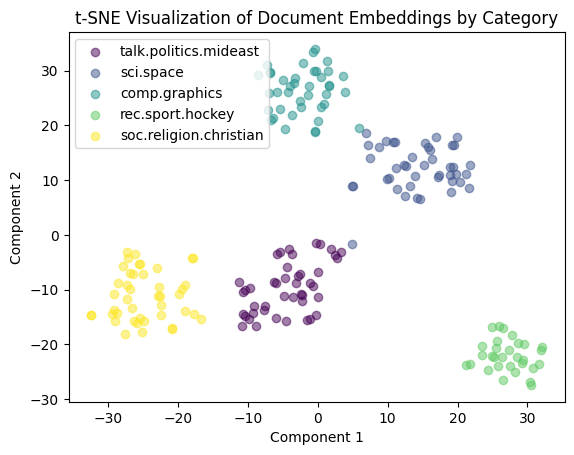

In [13]:
# Creates a nice set of colours for our visualisation.
base_cmap = matplotlib.colormaps.get_cmap('viridis')
colors = base_cmap(np.linspace(0, 1, len(categories)))  # Create a color range based on the number of categories
cmap = matplotlib.colors.ListedColormap(colors)

fig, ax = plt.subplots()
for idx, category in enumerate(categories):
    category_index = newsgroups.target_names.index(category)
    xs = [x[i] for i in range(len(x)) if targets[i] == category_index]
    ys = [y[i] for i in range(len(y)) if targets[i] == category_index]
    ax.scatter(xs, ys, color=cmap(idx), alpha=0.5, label=category)


ax.legend()
ax.set_title("t-SNE Visualization of Document Embeddings by Category")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")

# Clusters

This is looking good. Our visualisation shows that there are clearly some identifiable clusters so we'll use K Means to actually assign our documents to a cluster. First we'll fit our K Means clustering model.

In [14]:
k = len(categories)
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(doc_embeddings)
cluster_labels = kmeans.labels_

Now we have cluster labels, and we want to see how they match up with our actual target labels. We have two problems though.

1. Our original targets were selected from twenty categories, so we need to map them into the range 1, 2, 3, 4, 5.
2. K Means does not know anything about our original labels, so the classes it predicts will not necessarily match the target classes.

Solving problem 2 is tricky without further processing, so we'll simply look for a strong correlation between cluster labels and target labels in the confusion matrix, but we won't demand that they lie on the diagonal axis.

In [15]:
unique_target_classes = sorted(set(targets))
class_mapping = {original_class: new_class for new_class, original_class in enumerate(unique_target_classes, start=0)}
transformed_targets = [class_mapping[item] for item in targets]

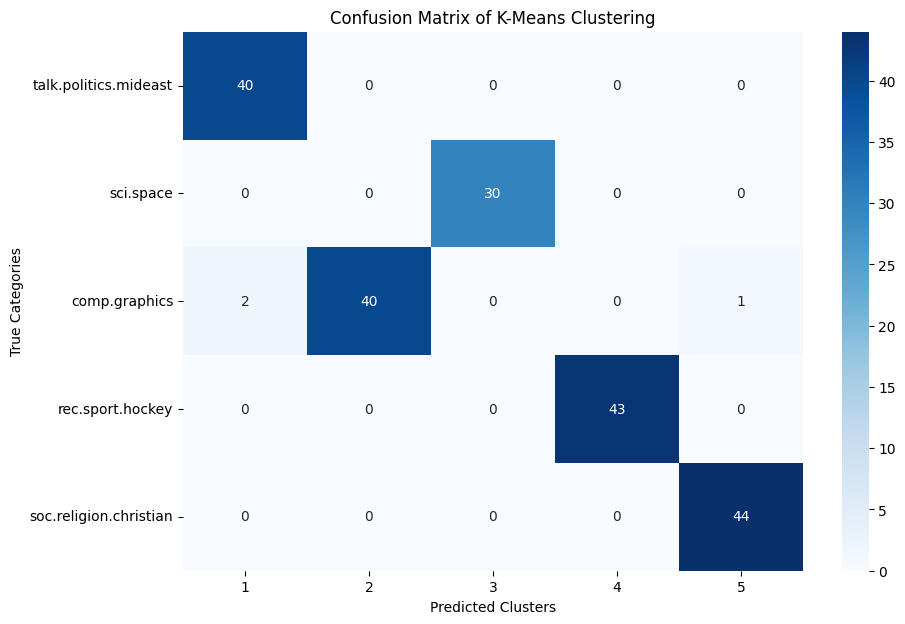

In [16]:
cm = confusion_matrix(transformed_targets, cluster_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, k+1), yticklabels=categories)
plt.xlabel('Predicted Clusters')
plt.ylabel('True Categories')
plt.title('Confusion Matrix of K-Means Clustering')
plt.show()